# Install additional Python libraries

In [1]:
# !pip install quantities

# Delete existing DB

In [2]:
!rm simoc_server/db.sqlite

# Import Python libraries

In [3]:
import json
from random import randint

In [4]:
import pprint
pp = pprint.PrettyPrinter()

In [5]:
from simoc_server import app, db
from simoc_server.database.db_model import User
from simoc_server.database.seed_data import seed
from simoc_server.game_runner import GameRunnerManager, GameRunnerInitializationParams
from simoc_server.agent_model.agents.core import GeneralAgent, StorageAgent
from simoc_server.database.db_model import AgentType

Unknown DB_TYPE variable: "None"
Using SQLite by default


In [6]:
from simoc_server.views import convert_configuration

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Agent model

In [8]:
db.drop_all()
db.create_all()
seed.seed('agent_desc.json')

# Create new user

In [9]:
username = 'user1'
password = 'user1'

user = User.query.filter_by(username=username).first()
if not user:
    print('Creating new user')
    user = User(username=username)
    user.set_password(password)
    db.session.add(user)
    db.session.commit()

Creating new user


# Initialize the ABM

In [10]:
game_config = {"agents": {
    "human_agent": [{"connections": {"air_storage": [1], "water_storage": [1, 2], "food_storage": [1]}, "amount": 10}],
    "cabbage": [{"connections": {"air_storage": [1], "water_storage": [1, 2], "nutrient_storage": [1],
                                 "power_storage": [1], "food_storage": [1]}, "amount": 10}],
    "lettuce": [{"connections": {"air_storage": [1], "water_storage": [1, 2], "nutrient_storage": [1],
                                 "power_storage": [1], "food_storage": [1]}, "amount": 10}],
    "greenhouse_medium": [{"connections": {"power_storage": [1]}, "amount": 1}],
    "solar_pv_array": [{"connections": {"power_storage": [1]}, "amount": 100}],
    "multifiltration_purifier_post_treament": [{"connections": {"water_storage": [1, 2]}, "amount": 1}],
    "urine_recycling_processor_VCD": [{"connections": {"power_storage": [1], "water_storage": [1, 2]}, "amount": 1}],
    "co2_removal_SAWD": [{"connections": {"power_storage": [1], "air_storage": [1]}, "amount": 1}]},
"storages": {
    "air_storage": [{"id": 1, "atmo_h2o": 100, "atmo_o2": 100, "atmo_co2": 100}],
    "water_storage": [{"id": 1, "h2o_potb": 100, "h2o_tret": 100}, {"id": 2, "h2o_wste": 100, "h2o_urin": 0}],
    "nutrient_storage": [{"id": 1, "sold_n": 100, "sold_p": 100, "sold_k": 100}],
    "power_storage": [{"id": 1, "enrg_kwh": 1000}],
    "food_storage": [{"id": 1, "food_edbl": 1000}]},
"termination": {
    "time": {"value": 2000, "unit": "hour"}},
    "food_leaf": {"value": 10000, "unit": "kg"},
    "evacuation": {}
}

In [11]:
# start_data = {"game_config": {'logging': {}, 'duration': {'value': 30, 'type': 'day'}, 'human_agent': {'amount': 4}, 'habitat': 'crew_habitat_small', 'greenhouse': 'greenhouse_small', 'food_storage': {'amount': 1000}, 'solar_arrays': {'amount': 60}, 'power_storage': {'amount': 1}, 'plants': [{'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 4}, {'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 3}]}}
start_data = {"game_config": {"priorities": ["inhabitants", "eclss", "plants", "storage"], 'logging': {'columns': ['agent_id', 'agent_type', 'value', 'unit'], 'filters': [('currency', ['enrg_kwh']), ('direction', ['in'])]}, 'duration': {'value': 30, 'type': 'day'}, 'human_agent': {'amount': 4}, 'habitat': 'crew_habitat_small', 'greenhouse': 'greenhouse_small', 'food_storage': {'amount': 1000}, 'solar_arrays': {'amount': 60}, 'power_storage': {'amount': 1}, 'plants': [{'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 4}, {'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 3}]}}
# start_data = {"game_config": {'logging': {'columns': ['agent_id', 'agent_type', 'value', 'unit'], 'filters': [('currency', ['enrg_kwh']), ('direction', ['in'])]}, 'duration': {'value': 30, 'type': 'day'}, 'human_agent': {'amount': 4}, 'habitat': 'crew_habitat_small', 'greenhouse': 'greenhouse_small', 'food_storage': {'amount': 1000}, 'solar_arrays': {'amount': 60}, 'power_storage': {'amount': 1}, 'plants': [{'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 4}, {'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 3}]}}
# start_data = {"game_config": {'duration': {'value': 30, 'type': 'day'}, 'human_agent': {'amount': 4}, 'habitat': 'crew_habitat_small', 'greenhouse': 'greenhouse_small', 'food_storage': {'amount': 1000}, 'solar_arrays': {'amount': 60}, 'power_storage': {'amount': 1}, 'plants': [{'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 4}, {'species': 'rice', 'amount': 100}, {'species': 'wheat', 'amount': 30}, {'species': 'cabbage', 'amount': 3}]}}
pp.pprint(start_data)

{'game_config': {'duration': {'type': 'day', 'value': 30},
                 'food_storage': {'amount': 1000},
                 'greenhouse': 'greenhouse_small',
                 'habitat': 'crew_habitat_small',
                 'human_agent': {'amount': 4},
                 'logging': {'columns': ['agent_id',
                                         'agent_type',
                                         'value',
                                         'unit'],
                             'filters': [('currency', ['enrg_kwh']),
                                         ('direction', ['in'])]},
                 'plants': [{'amount': 100, 'species': 'rice'},
                            {'amount': 30, 'species': 'wheat'},
                            {'amount': 4, 'species': 'cabbage'},
                            {'amount': 100, 'species': 'rice'},
                            {'amount': 30, 'species': 'wheat'},
                            {'amount': 3, 'species': 'cabbage'}],
            

In [12]:
game_config = convert_configuration(start_data["game_config"])
pp.pprint(game_config)

{'agents': {'cabbage': [{'amount': 3,
                         'connections': {'air_storage': [1],
                                         'food_storage': [1],
                                         'nutrient_storage': [1],
                                         'power_storage': [1],
                                         'water_storage': [1, 2]}}],
            'co2_reduction_sabatier': [{'amount': 1,
                                        'connections': {'air_storage': [1],
                                                        'power_storage': [1],
                                                        'water_storage': [1,
                                                                          2]}}],
            'co2_removal_SAWD': [{'amount': 1,
                                  'connections': {'air_storage': [1],
                                                  'power_storage': [1]}}],
            'crew_habitat_small': [{'amount': 1,
                                   

In [13]:
game_runner_manager = GameRunnerManager()
game_runner_init_params = GameRunnerInitializationParams(game_config)
game_runner_manager.new_game(user, game_runner_init_params)
game_runner = game_runner_manager.get_game_runner(user)

# Run the simiulation

In [14]:
def run_sim(game_runner_manager, user, num_steps):
    for i in range(1, num_steps + 1):
        agent_model_state = game_runner_manager.get_step(user, i)
    pp.pprint(agent_model_state)

In [15]:
%%time
run_sim(game_runner_manager, user, 10)

{'agents': {'total_agent_types': {'cabbage': 3,
                                  'co2_reduction_sabatier': 1,
                                  'co2_removal_SAWD': 1,
                                  'crew_habitat_small': 1,
                                  'greenhouse_small': 1,
                                  'human_agent': 4,
                                  'multifiltration_purifier_post_treament': 1,
                                  'oxygen_generation_SFWE': 1,
                                  'rice': 100,
                                  'solar_pv_array_mars': 60,
                                  'solid_waste_aerobic_bioreactor': 1,
                                  'urine_recycling_processor_VCD': 1,
                                  'wheat': 30},
            'total_consumption': {'atmo_co2': {'units': 'kg',
                                               'value': '0.0848'},
                                  'atmo_h2': {'units': 'kg', 'value': '0.0016'},
               

In [16]:
storages = game_runner.agent_model.get_agents_by_class(agent_class=StorageAgent)

In [17]:
agent_class = AgentType.query.get(storages[0]._agent_type_id).agent_class

In [18]:
def get_logs(logs, filters=[], columns=None, dtype='list'):
    df = pd.DataFrame(logs)
    for col, val in filters:
        df = df.loc[df[col].isin(val)].drop(col, axis=1)
    if columns:
        df = df.loc[:, columns]
    if dtype == 'list':
        return df.values.tolist()
    elif dtype == 'dict':
        return df.to_dict(orient='records')
    elif dtype == 'df':
        return df

def get_step_logs(logs, step_num, filters=[], columns=None, dtype='list'):
    return get_logs(logs, filters=filters+[('step_num', [step_num])], columns=columns, dtype=dtype)

In [19]:
logs = game_runner.agent_model.logs
print(len(logs))

23786


In [20]:
step_num = 0

# filters = [('currency', ['enrg_kwh']), ('direction', ['in'])]
filters = []

# cols = ['agent_id', 'unit']
cols = []

# df = get_step_logs(logs, step_num, filters, columns=cols, dtype='df')
df = game_runner.agent_model.get_step_logs(step_num, filters, columns=cols, dtype='df')

In [21]:
df.head()

,agent_id,agent_type,currency,direction,storage_id,storage_type,unit,value
0,GeneralAgent_2e56d7b0,human_agent,atmo_o2,in,1,air_storage,1.0 kg,0.049200
1,GeneralAgent_2e56d7b0,human_agent,h2o_potb,in,1,water_storage,1.0 kg,0.212083
2,GeneralAgent_2e56d7b0,human_agent,h2o_potb,in,2,water_storage,1.0 kg,0.212083
3,GeneralAgent_2e56d7b0,human_agent,food_edbl,in,1,food_storage,1.0 kg,0.099750
4,GeneralAgent_2e56d7b0,human_agent,atmo_co2,out,1,air_storage,1.0 kg,0.064000


In [22]:
df.columns

Index(['agent_id', 'agent_type', 'currency', 'direction', 'storage_id',
       'storage_type', 'unit', 'value'],
      dtype='object')

In [23]:
df.agent_type.value_counts()

rice                                      900
wheat                                     270
human_agent                                40
cabbage                                    27
co2_reduction_sabatier                      6
solid_waste_aerobic_bioreactor              3
co2_removal_SAWD                            2
urine_recycling_processor_VCD               2
oxygen_generation_SFWE                      2
multifiltration_purifier_post_treament      2
Name: agent_type, dtype: int64

In [24]:
# filters = [('currency', ['enrg_kwh']), ('direction', ['in'])]
filters = []

# cols = ['agent_id', 'unit']
cols = []

# df = get_logs(logs, filters=filters, columns=cols, dtype='df')
df = game_runner.agent_model.get_logs(filters=filters, columns=cols, dtype='df')

In [25]:
df.head()

,agent_id,agent_type,currency,direction,step_num,storage_id,storage_type,unit,value
0,GeneralAgent_2e56d7b0,human_agent,atmo_o2,in,0,1,air_storage,1.0 kg,0.049200
1,GeneralAgent_2e56d7b0,human_agent,h2o_potb,in,0,1,water_storage,1.0 kg,0.212083
2,GeneralAgent_2e56d7b0,human_agent,h2o_potb,in,0,2,water_storage,1.0 kg,0.212083
3,GeneralAgent_2e56d7b0,human_agent,food_edbl,in,0,1,food_storage,1.0 kg,0.099750
4,GeneralAgent_2e56d7b0,human_agent,atmo_co2,out,0,1,air_storage,1.0 kg,0.064000


In [26]:
# game_runner.agent_model.get_logs(filters=filters, columns=cols, dtype='list')[:5]

In [27]:
# import cProfile
# cProfile.run('run_sim(game_runner_manager, user, 10)', filename='simoc.cprof' )

In [28]:
# from profiling.tracing import TracingProfiler
# profiler = TracingProfiler()
# profiler.start()
# run_sim(game_runner_manager, user, 10)
# profiler.stop()

In [29]:
# profiler.run_viewer()

In [30]:
# profiler.dump('simoc.profiler')

In [31]:
# game_runner_manager.save_all(allow_repeat_save=False)

In [32]:
# game_runner.agent_model.get_total_storages()

In [33]:
# game_runner.agent_model.get_total_agents()

In [34]:
# game_runner.agent_model.get_model_stats()

In [35]:
def get_sigmoid_step(step_num, max_value, num_values, min_value=0, center=None, steepness=0.5):
    center = center if center else int(num_values / 2)
    y = ((max_value - min_value) / (1. + np.exp(-steepness * (step_num - center)))) + min_value
    return y

def get_log_step(step_num, max_value, num_values, min_value=0, zero_value=1e-2):
    zero_value = zero_value if zero_value < max_value else max_value * zero_value
    y = np.geomspace(zero_value, max_value - min_value, num_values) + min_value
    return y[step_num]

def get_linear_step(step_num, max_value, num_values, min_value=0):
    y = np.linspace(min_value, max_value, num_values)
    return y[step_num]

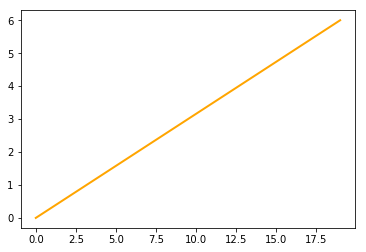

In [36]:
min_value, max_value, num_values = 0, 6, 20

y = []
for i in range(num_values):
#     y.append(get_linear_step(i, max_value, num_values, min_value))
    y.append(get_linear_step(i, max_value, num_values))

plt.plot(y, lw=2, color='orange')

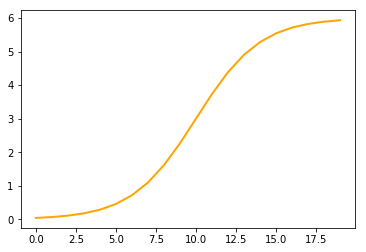

In [37]:
min_value, max_value, num_values = 0, 6, 20
center, steepness = 10, 0.5

y = []
for i in range(num_values):
#     y.append(get_sigmoid_step(i, max_value, num_values, min_value, center, steepness))
    y.append(get_sigmoid_step(i, max_value, num_values))

plt.plot(y, lw=2, color='orange')

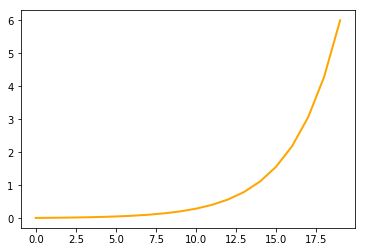

In [38]:
min_value, max_value, num_values = 0, 6, 20

y = []
for i in range(num_values):
#     y.append(get_log_step(i, max_value, num_values, min_value))
    y.append(get_log_step(i, max_value, num_values))

plt.plot(y, lw=2, color='orange')